<a href="https://colab.research.google.com/github/yayonecathy/USphone_casestudy/blob/main/US_Smartphone_2025_Forecast(Cathy_Lee)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code snippet 0
#Installing necessary packages
!pip install numpy==1.24.4
!pip install --upgrade prophet holidays
!pip install scikit-learn==0.24

  Using cached scikit-learn-0.24.0.tar.gz (7.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for scikit-learn (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
Failed to build scikit-learn
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (scikit-learn)


In [ ]:
#Code Snippet 1
#Importing the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import holidays
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error



In [ ]:
#Code Snippet 2
#Load the dataset from GitHub
url = "https://raw.githubusercontent.com/yayonecathy/USphone_casestudy/refs/heads/main/Case%20Study_0422.xlsx%20-%20raw.csv"
df = pd.read_csv(url)


<ipython-input-16-009f25b8758e>:4: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


In [ ]:
#code snippet 3
#show columns with mixed types

for col in df.columns:
    if df[col].dtype == 'object':
        if len(df[col].unique()) > 1 and not all(isinstance(x, str) for x in df[col].unique()):
            print(f"Column '{col}' has mixed types.")


Column 'Market Name' has mixed types.
Column 'ModelCD' has mixed types.
Column 'Program' has mixed types.
Column 'FRP' has mixed types.
Column 'Revenue(FRP)' has mixed types.


In [ ]:
#Code Snippet 4
#from column 'DeviceSub', filter only SMART, in order to get Smartphone values

df = df[df['DeviceSub'] == 'SMART']


In [ ]:
#code snippet 5
#getting rid of commas in the data for data prep
cols_to_convert = ['Revenue(FRP)', 'SellOut', 'FRP']

for col in cols_to_convert:
    df[col] = df[col].astype(str).str.replace(',', '').str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

<ipython-input-19-db70e7334109>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).str.replace(',', '').str.strip()


,Year,Semi-Year,Week,Month,Quarter,Account,Carrier,Vendor,Vendor.1,Market Name,...,Device,DeviceSub,OS,Touch,Querty,SellOut,FRP,Revenue(FRP),Price Band(FRP),PRICE TIER(FRP)
0,2022,2022 1H,202201,202201,2022Q1,Verizon,Verizon,Motorola,OA,DROID 4,...,Phone,SMART,Android,Yes,Yes,3443,504.90,1738370.70,499.95-549.94,Mid
1,2022,2022 1H,202201,202201,2022Q1,Verizon,Verizon,Motorola,OA,DROID RAZR HD,...,Phone,SMART,Android,Yes,No,6026,592.90,3572815.40,549.95-599.94,Mid
2,2022,2022 1H,202201,202201,2022Q1,Verizon,Verizon,Motorola,OA,DROID RAZR HD MAXX,...,Phone,SMART,Android,Yes,No,4304,702.90,3025281.60,699.95-749.94,Base Premium
3,2022,2022 1H,202201,202201,2022Q1,Verizon,Verizon,Motorola,OA,DROID HD,...,Phone,SMART,Android,Yes,No,17217,471.90,8124702.30,449.95-499.94,Mid
4,2022,2022 1H,202201,202201,2022Q1,Verizon,Verizon,Motorola,OA,DROID RAZR,...,Phone,SMART,Android,Yes,No,3013,581.90,1753264.70,549.95-599.94,Mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88703,2024,2024 2H,202453,202412,2024Q4,Unlocked,Unlocked(CI INFLOW),Samsung,Samsung,NaN,...,Phone,SMART,Android,Yes,No,4,302.55,1210.20,299.95-349.94,Mid
88704,2024,2024 2H,202453,202412,2024Q4,Unlocked,Unlocked(CI INFLOW),Samsung,Samsung,NaN,...,Phone,SMART,Android,Yes,No,14,302.55,4235.70,299.95-349.94,Mid
88705,2024,2024 2H,202453,202412,2024Q4,Unlocked,Unlocked(CI INFLOW),Samsung,Samsung,NaN,...,Phone,SMART,Android,Yes,No,193,302.55,58392.15,299.95-349.94,Mid
88706,2024,2024 2H,202453,202412,2024Q4,Unlocked,Unlocked(CI INFLOW),Samsung,Samsung,NaN,...,Phone,SMART,Android,Yes,No,17,302.55,5143.35,299.95-349.94,Mid


In [ ]:
#code snippet 6

#Drop missing values
df.dropna(subset=['SellOut', 'Revenue(FRP)', 'FRP'], inplace=True)

# Convert Week to datetime
df['Week'] = df['Week'].astype(str).str.zfill(6)
df['ds'] = pd.to_datetime(df['Week'] + '0', format='%Y%W%w')

#Weekly Aggregation
weekly_df = df.groupby('ds').agg({
    'SellOut': 'sum',
    'Revenue(FRP)': 'sum',
    'FRP': 'mean'
}).reset_index().rename(columns={'FRP': 'ASP'})

In [ ]:
#Code snippet 7
#US Federal Holidays for 2022–2026
us_holidays = holidays.US(years=[2022, 2023, 2024, 2025, 2026])
holiday_df = pd.DataFrame({
    'ds': pd.to_datetime(list(us_holidays.keys())),
    'holiday': 'US_Holiday'
})


<Axes: >

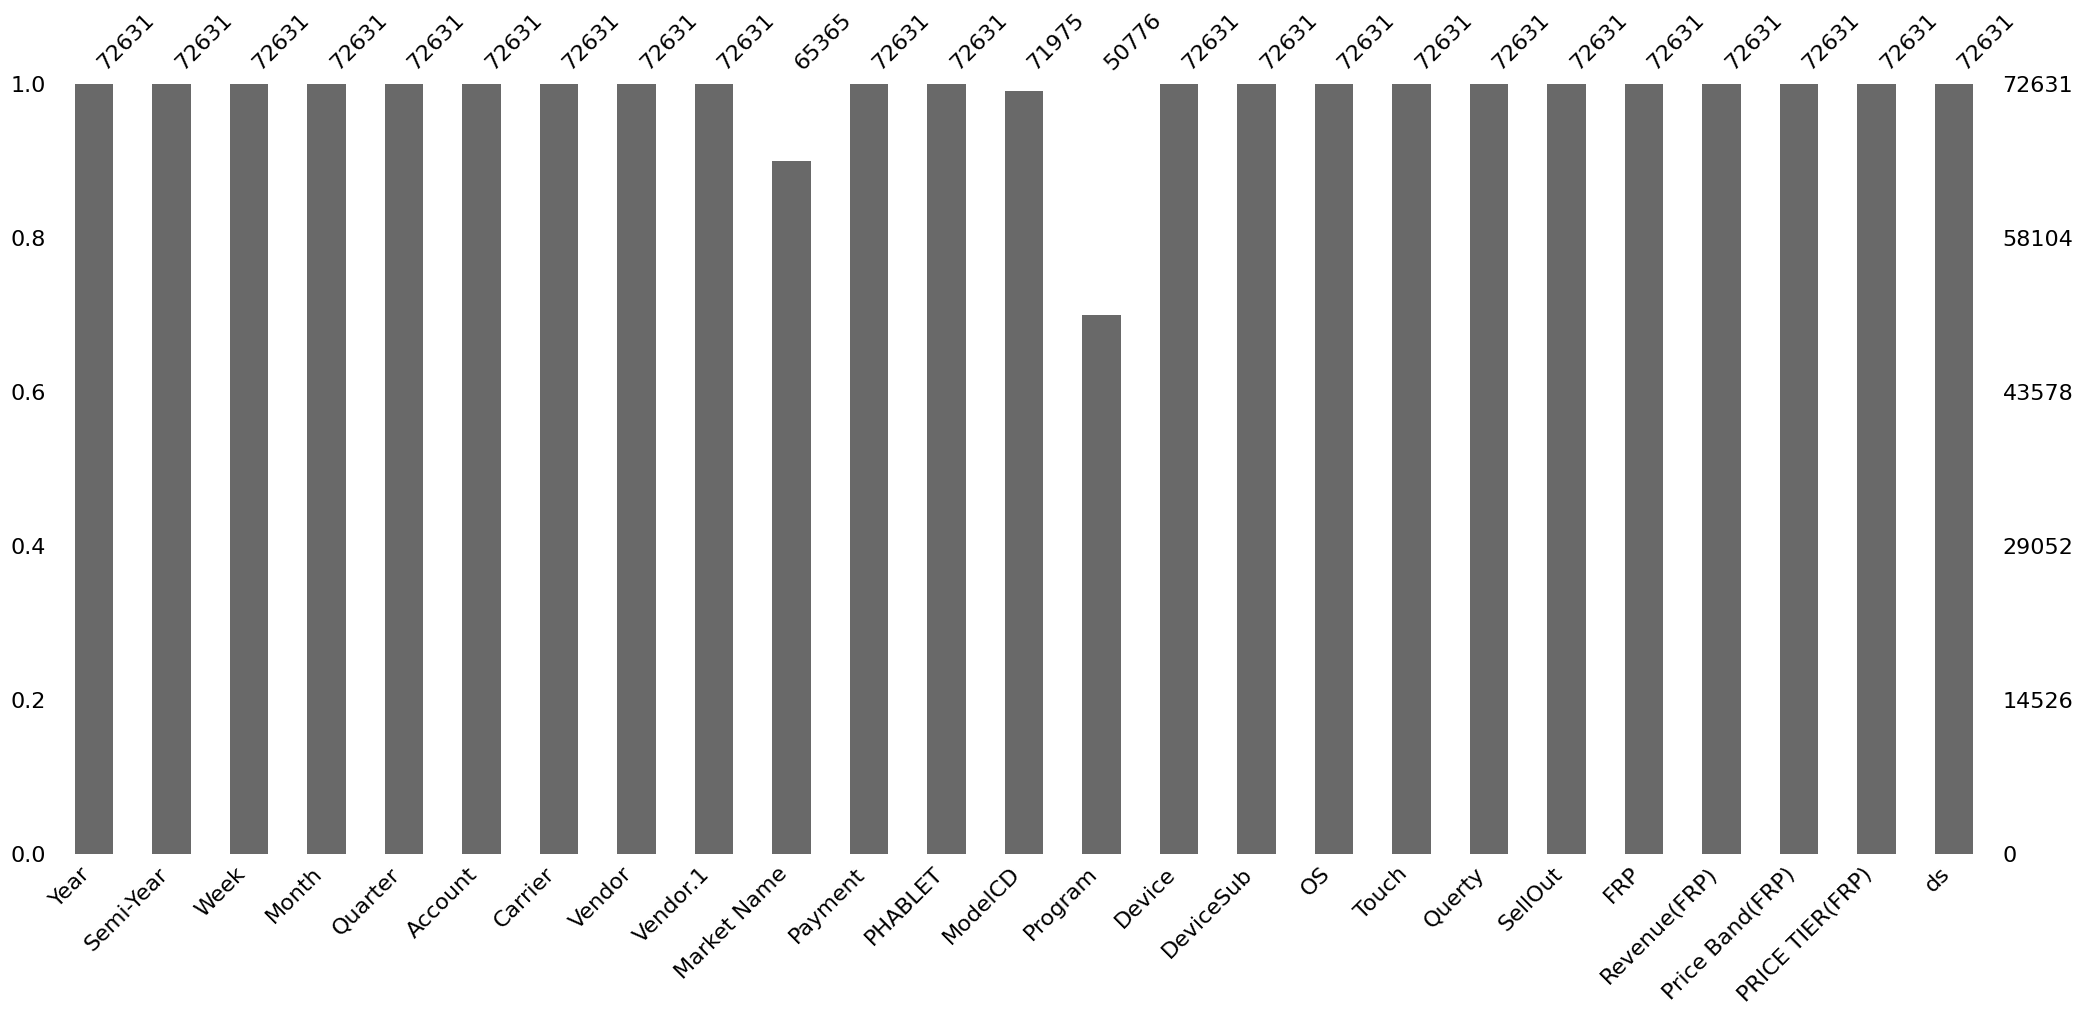

In [ ]:
#Code snippet 8
#showing missing values in bars
import missingno as msno
msno.bar(df)

In [ ]:
#code snippet 9
#drop values with more than 20% missing

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# Identify columns with more than 20% missing values
columns_to_drop = missing_percentage[missing_percentage > 20].index

# Drop the identified columns
df.drop(columns=columns_to_drop, inplace=True)
columns_to_drop

Index(['Program'], dtype='object')

In [ ]:
#Code snippet 10
#Forecast prep for Volume(Sellout), Revenue, and ASP

# Forecast with diagnostics and evaluation
def forecast_with_diagnostics(data, y_col, label):
    print(f"\n Modeling {label}...\n")

    # Prophet expects 'ds' and 'y' columns
    df_prophet = data.rename(columns={y_col: 'y'})

    # Initialize model and factor in holidays
    m = Prophet(holidays=holiday_df, yearly_seasonality=True, weekly_seasonality=True)
    m.fit(df_prophet)

    # Create future dataframe (52 weeks ahead)
    future = m.make_future_dataframe(periods=52, freq='W')
    forecast = m.predict(future)

    #  Plot forecast
    plt.figure(figsize=(12, 5))
    plt.plot(data['ds'], data[y_col], label='Historical')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.title(f'{label} Forecast (Next 52 Weeks)')
    plt.xlabel('Week')
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Evaluation (training period only)
    forecast_train = forecast[forecast['ds'] <= data['ds'].max()]
    actual = df_prophet.set_index('ds').loc[forecast_train['ds']]['y'].values
    predicted = forecast_train['yhat'].values

    mae = mean_absolute_error(actual, predicted)
    # Removing 'squared' argument to calculate MSE
    rmse = np.sqrt(mean_squared_error(actual, predicted)) # Taking the square root to get RMSE
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    print(f"\n Evaluation Metrics for {label}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    #  Filter only future forecast
    future_forecast = forecast[forecast['ds'] > data['ds'].max()][['ds', 'yhat']]
    future_forecast.columns = ['Week', f'Forecasted_{label}']
    return future_forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Modeling SellOut...



DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0ngvfc1/txm1dmyb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0ngvfc1/lcpuqvgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35477', 'data', 'file=/tmp/tmpx0ngvfc1/txm1dmyb.json', 'init=/tmp/tmpx0ngvfc1/lcpuqvgd.json', 'output', 'file=/tmp/tmpx0ngvfc1/prophet_model1v02zkps/prophet_model-20250428182240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


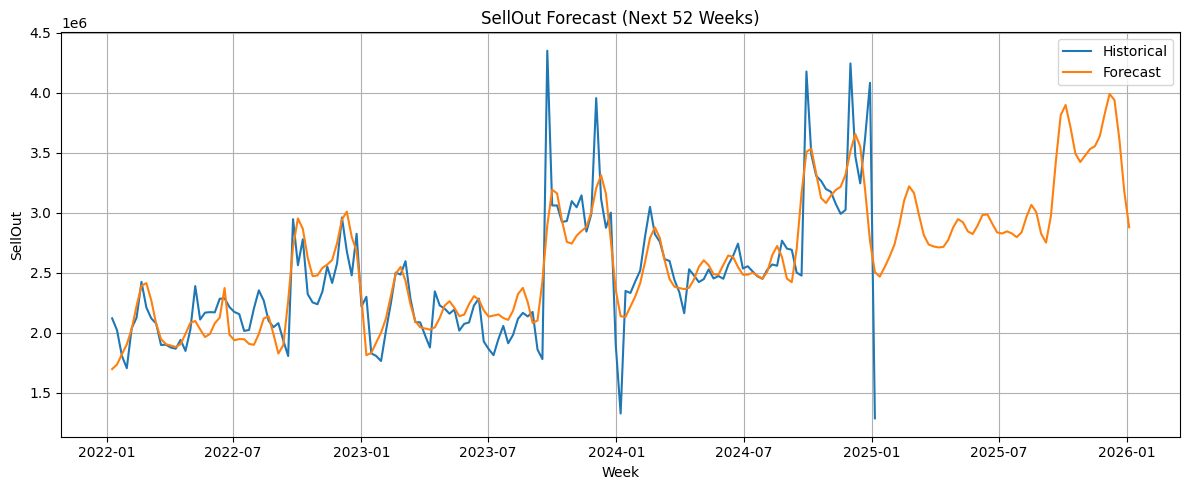

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Evaluation Metrics for SellOut:
MAE: 189175.19
RMSE: 292341.60
MAPE: 7.96%

 Modeling Revenue...



DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0ngvfc1/57hmk1qx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0ngvfc1/xn1th6zq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=216', 'data', 'file=/tmp/tmpx0ngvfc1/57hmk1qx.json', 'init=/tmp/tmpx0ngvfc1/xn1th6zq.json', 'output', 'file=/tmp/tmpx0ngvfc1/prophet_modelh2uzfa6e/prophet_model-20250428182243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


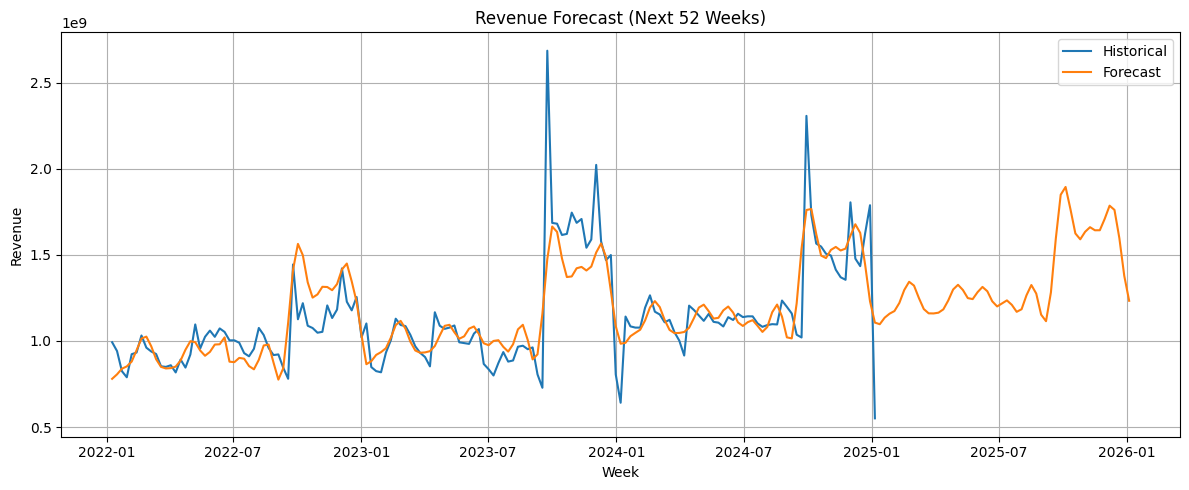

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Evaluation Metrics for Revenue:
MAE: 117310220.76
RMSE: 187189946.40
MAPE: 10.37%

 Modeling ASP...



DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0ngvfc1/lwnzd5h0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0ngvfc1/awdiq73y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4875', 'data', 'file=/tmp/tmpx0ngvfc1/lwnzd5h0.json', 'init=/tmp/tmpx0ngvfc1/awdiq73y.json', 'output', 'file=/tmp/tmpx0ngvfc1/prophet_modelchb3x12q/prophet_model-20250428182246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


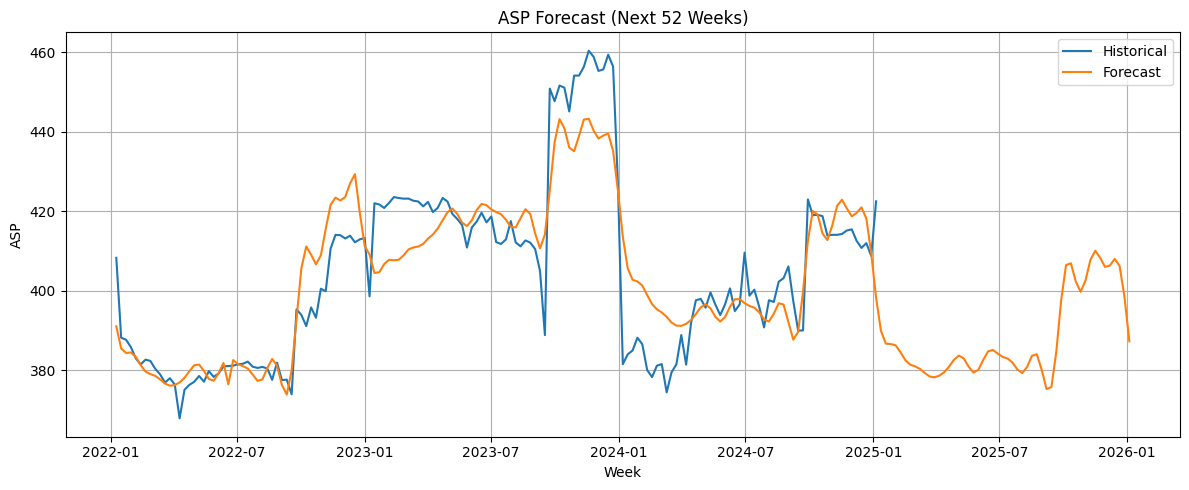


 Evaluation Metrics for ASP:
MAE: 7.64
RMSE: 10.11
MAPE: 1.86%

 Forecasted SellOut (next 52 weeks):
          Week  Forecasted_SellOut
157 2025-01-12        2.466747e+06
158 2025-01-19        2.545667e+06
159 2025-01-26        2.633074e+06
160 2025-02-02        2.733862e+06
161 2025-02-09        2.900502e+06

 Forecasted Revenue (next 52 weeks):
          Week  Forecasted_Revenue
157 2025-01-12        1.097270e+09
158 2025-01-19        1.135272e+09
159 2025-01-26        1.158444e+09
160 2025-02-02        1.173804e+09
161 2025-02-09        1.220664e+09

 Forecasted ASP (next 52 weeks):
          Week  Forecasted_ASP
157 2025-01-12      389.903518
158 2025-01-19      386.695579
159 2025-01-26      386.589693
160 2025-02-02      386.283426
161 2025-02-09      384.566592


In [ ]:
#code snippet 11
#Run the forecasts
sellout_forecast = forecast_with_diagnostics(weekly_df[['ds', 'SellOut']], 'SellOut', 'SellOut')
revenue_forecast = forecast_with_diagnostics(weekly_df[['ds', 'Revenue(FRP)']], 'Revenue(FRP)', 'Revenue')
asp_forecast = forecast_with_diagnostics(weekly_df[['ds', 'ASP']], 'ASP', 'ASP')

#Display forecasts
print("\n Forecasted SellOut (next 52 weeks):")
print(sellout_forecast.head())

print("\n Forecasted Revenue (next 52 weeks):")
print(revenue_forecast.head())

print("\n Forecasted ASP (next 52 weeks):")
print(asp_forecast.head())

In [ ]:
# code snippet 12

# Combine the forecasts into a single DataFrame
combined_forecast = pd.merge(sellout_forecast, revenue_forecast, on='Week', how='outer')
combined_forecast = pd.merge(combined_forecast, asp_forecast, on='Week', how='outer')

# Display the combined forecast
print("\n Combined Forecast (next 52 weeks):")
print(combined_forecast.head())



 Combined Forecast (next 52 weeks):
        Week  Forecasted_SellOut  Forecasted_Revenue  Forecasted_ASP
0 2025-01-12        2.466747e+06        1.097270e+09      389.903518
1 2025-01-19        2.545667e+06        1.135272e+09      386.695579
2 2025-01-26        2.633074e+06        1.158444e+09      386.589693
3 2025-02-02        2.733862e+06        1.173804e+09      386.283426
4 2025-02-09        2.900502e+06        1.220664e+09      384.566592


In [ ]:
#code snippet 13
#exporting the forecast to csv file
combined_forecast.to_csv('2025_forecast.csv', index=False)